In [2]:
import os
import fnmatch
import yaml as yaml
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path
import parse
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def load_dataset_solar(dataset_name):
        
        path: Path =  Path("./") / f"{dataset_name}.txt"
        #(
        ##    Path(__file__).parent
        #    / f"./dataset/{dataset_name}.txt"
        #)
        
        if not path.is_file():
            raise ValueError(f"Expected file with solar data in path {path}.")
        
        data: pd.DataFrame = pd.read_csv(
                                    path,
                                    sep = ',',
                                    skiprows=11, index_col = False)
        data.columns = ["date", "current_mA"]
        
        
        with open(path, "r") as f:
            for _ in range(2):
                line = f.readline()
            number_of_days = parse.search("Days: {:d}", line)[0] 
        
        # In Return: We skip the first day values here "data["current_mA"][288:].reset_index()"
        # since this is how it is done in C++ code by Lars

        return data["current_mA"][288:].reset_index(drop=True), number_of_days

## Set Configuration

In [4]:
dataset_solar_name = "TUHHx"
dataset_camera_name = "skistua" #Available Cameras: ['jervskogen_1', 'jervskogen_2', 'nilsbyen_2', 'nilsbyen_3', 'skistua']
days = 80
total_rows = 288 * days
shift_value = 9
normalization = False

configuration  = {
            "start_day" : "2021-12-11",
            "days": days,
            "solar_scale": 1
        }

[4.11778333e-03 5.92956667e-03 3.95307500e-03 9.88275000e-04
 4.61192500e-03 3.62362500e-03 4.28250000e-03 2.33562917e-01
 7.81393333e-01 1.25083333e+00 1.85994167e+00 9.24262500e+00
 1.55519167e+01 2.42134167e+01 2.96802500e+01 2.60257500e+01
 1.84069167e+01 2.21307550e+00 1.31768917e-02 5.92954167e-03
 5.27077500e-03 3.62365000e-03 3.95306667e-03 2.30595000e-03]


<AxesSubplot: >

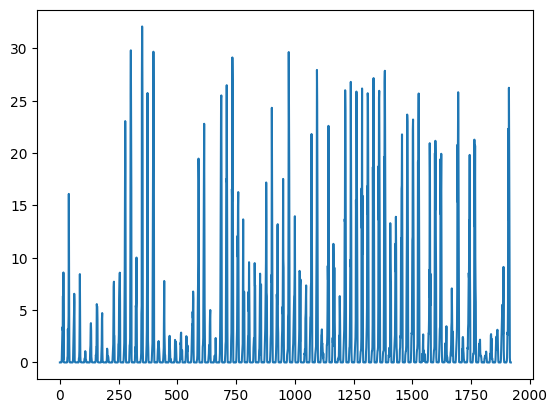

In [27]:
solar_data,  number_of_days = load_dataset_solar(dataset_solar_name)
#print(solar_data)

solar_df: pd.DataFrame = pd.DataFrame()
solar_df["current_mA"] =  solar_data * configuration["solar_scale"] 

# Reset the index of solar_df
solar_df.reset_index(drop=True, inplace=True)

# Print solar_df to verify data
#print(solar_df)
solar_df = solar_df["current_mA"][:total_rows]
solar_averaged_df = solar_df.groupby(solar_df.index // 12).mean(numeric_only=True)
print(solar_averaged_df[24*16:24*17].values)
# Print solar_averaged_df to verify the result
#print(solar_averaged_df)
solar_averaged_df.plot()

In [6]:
solar_df

0        0.000000
1        0.000000
2        0.000000
3        0.007906
4        0.009883
           ...   
23035    0.000000
23036    0.000000
23037    0.000000
23038    0.000000
23039    0.000000
Name: current_mA, Length: 23040, dtype: float64

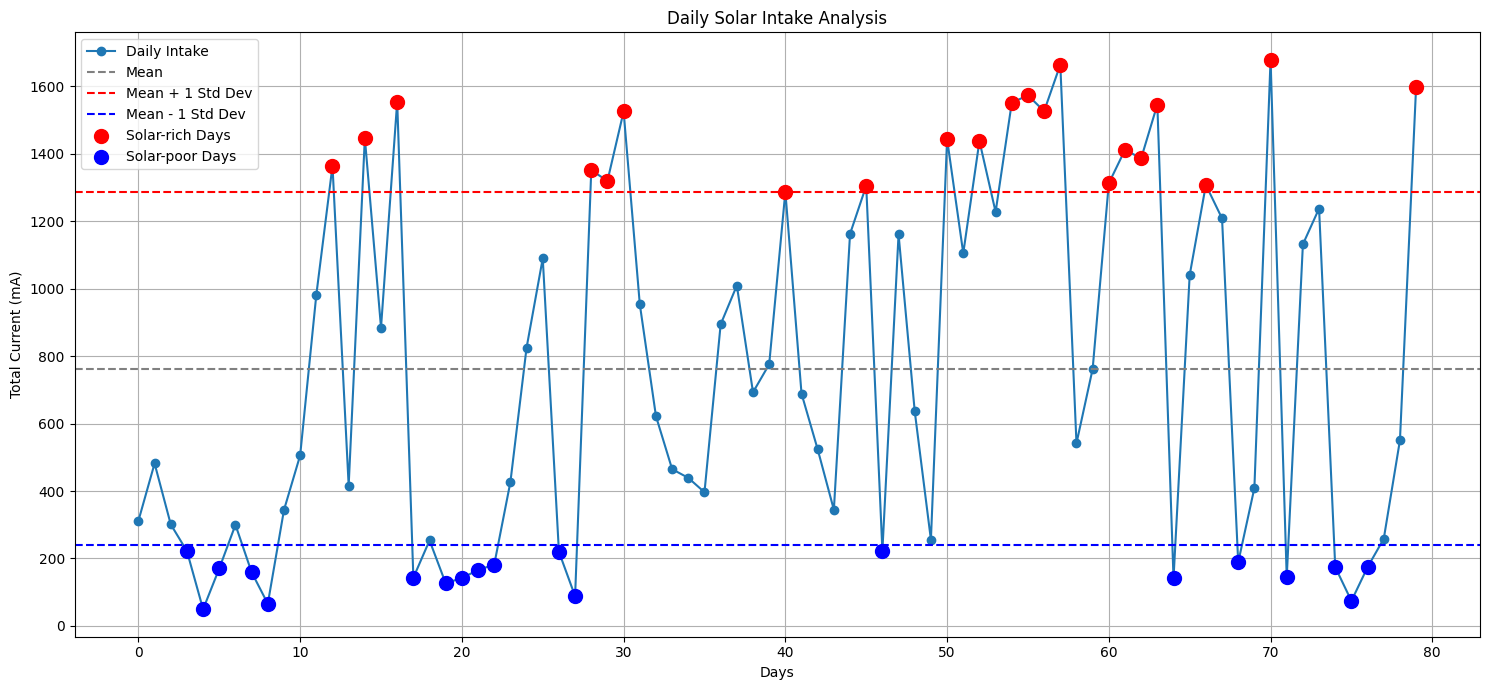

In [7]:
# Reshape the data to have 288 columns (one for each 5 min interval of the day)
daily_data = np.array(solar_df).reshape(-1, 288)

# Sum each row to get daily intake
daily_sums = daily_data.sum(axis=1)

# Calculate the mean and standard deviation
mean_daily = daily_sums.mean()
std_daily = daily_sums.std()

# Determine solar-rich and solar-poor days
days = np.arange(len(daily_sums))
solar_rich = daily_sums > mean_daily + std_daily
solar_poor = daily_sums < mean_daily - std_daily

# Visualize the results
plt.figure(figsize=(15, 7))
plt.plot(days, daily_sums, marker='o', label='Daily Intake')
plt.axhline(mean_daily, color='grey', linestyle='--', label='Mean')
plt.axhline(mean_daily + std_daily, color='red', linestyle='--', label='Mean + 1 Std Dev')
plt.axhline(mean_daily - std_daily, color='blue', linestyle='--', label='Mean - 1 Std Dev')

plt.scatter(days[solar_rich], daily_sums[solar_rich], color='red', s=100, label='Solar-rich Days', zorder=5)
plt.scatter(days[solar_poor], daily_sums[solar_poor], color='blue', s=100, label='Solar-poor Days', zorder=5)

plt.title('Daily Solar Intake Analysis')
plt.xlabel('Days')
plt.ylabel('Total Current (mA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

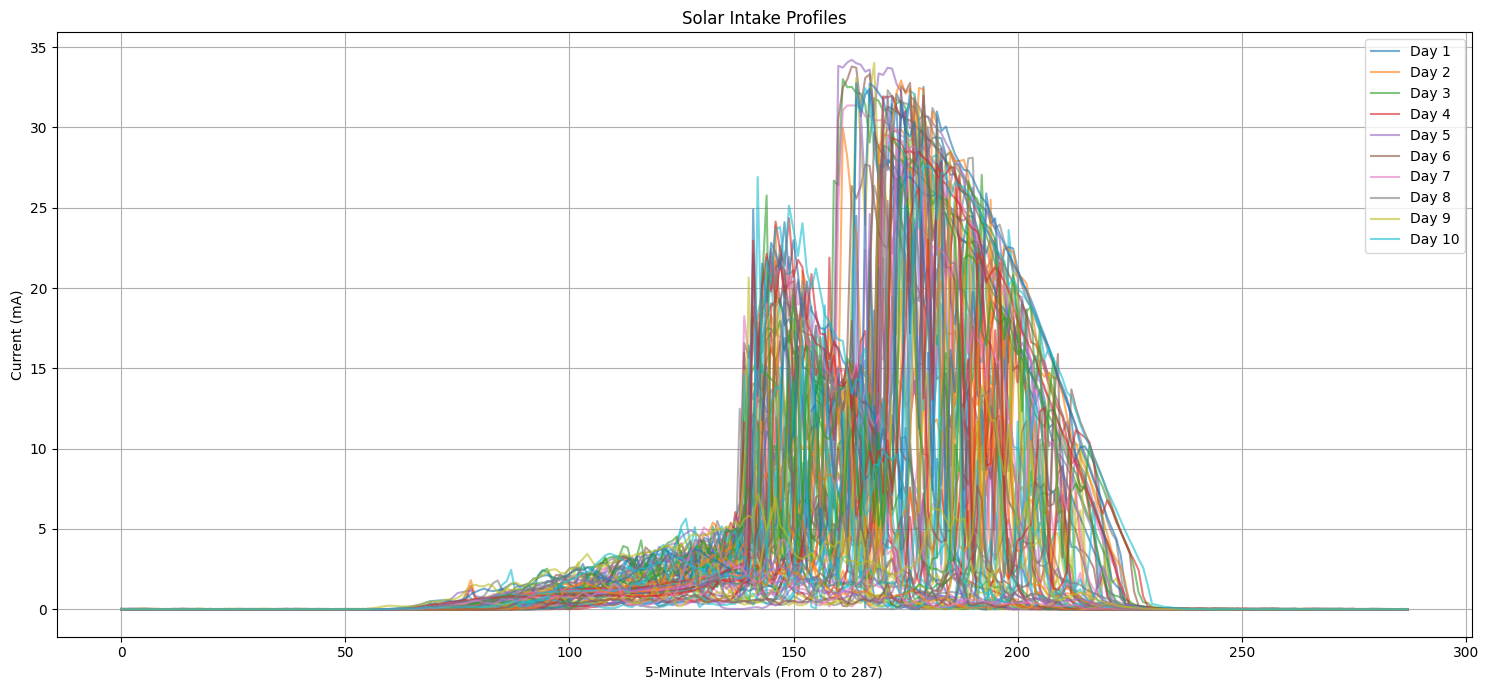

In [8]:
# Reshape the data to have 288 columns (one for each 5 min interval of the day)
daily_data = np.array(solar_df).reshape(-1, 288)

# Define x values (5-minute intervals)
x_values = np.arange(288)

# Plot the profiles
plt.figure(figsize=(15, 7))

for i, daily_profile in enumerate(daily_data):
    plt.plot(x_values, daily_profile, label=f'Day {i+1}' if i < 10 else "", alpha=0.6)

plt.title('Solar Intake Profiles')
plt.xlabel('5-Minute Intervals (From 0 to 287)')
plt.ylabel('Current (mA)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

plt.show()

[[0.0000e+00 0.0000e+00 0.0000e+00 7.9062e-03 9.8827e-03 7.9062e-03
  1.9765e-03 0.0000e+00 0.0000e+00 3.9531e-03 0.0000e+00 3.9531e-03
  3.9531e-03 0.0000e+00 0.0000e+00 0.0000e+00 5.9296e-03 0.0000e+00
  0.0000e+00 1.1859e-02 5.9296e-03 3.9531e-03 0.0000e+00 1.3836e-02
  5.9296e-03 0.0000e+00 5.9296e-03 1.3836e-02 0.0000e+00 0.0000e+00
  1.3836e-02 0.0000e+00 7.9062e-03 7.9062e-03 0.0000e+00 0.0000e+00
  3.9531e-03 0.0000e+00 0.0000e+00 1.7789e-02 5.9296e-03 0.0000e+00
  0.0000e+00 7.9062e-03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 1.1859e-02 0.0000e+00 5.9296e-03
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  3.9531e-03 0.0000e+00 3.9531e-03 0.0000e+00 0.0000e+00 5.9296e-03
  1.1859e-02 5.9296e-03 0.0000e+00 0.0000e+00 0.0000e+00 7.9062e-03
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.9531e-03 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.1859e-02 1.5812e-02
  3.9531e-03 0.0000e+00 0.0000e+00 0.0000e+00 0.

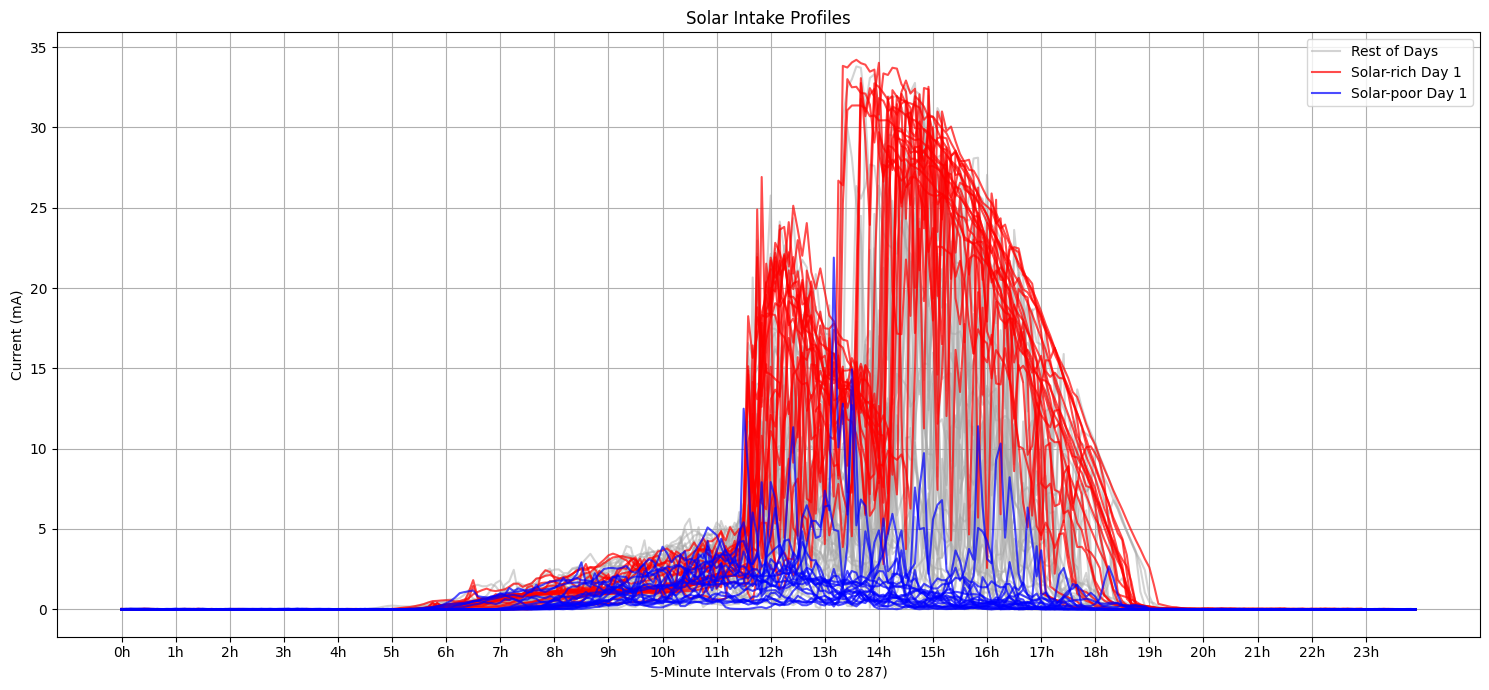

In [16]:
# Reshape the data to have 288 columns (one for each 5 min interval of the day)
daily_data = np.array(solar_df).reshape(-1, 288)
print(daily_data[:1])
# Calculate daily sums
daily_sums = daily_data.sum(axis=1)

# Calculate the mean and standard deviation
mean_daily = daily_sums.mean()
std_daily = daily_sums.std()

# Determine solar-rich and solar-poor days
solar_rich = daily_sums > mean_daily + std_daily
solar_poor = daily_sums < mean_daily - std_daily

# Define x values (5-minute intervals)
x_values = np.arange(288)

# Plot the profiles
plt.figure(figsize=(15, 7))

# Plot all days (not solar rich and poor) with a light gray color as background
for i, daily_profile in enumerate(daily_data):
    if not (solar_rich[i] or solar_poor[i]):
        plt.plot(x_values, daily_profile, color='darkgray', alpha=0.5, label='Rest of Days' if 'Rest of Days' not in [l.get_label() for l in plt.gca().get_lines()] else "")

# Overplot the solar-rich and solar-poor days with distinct colors
for i, daily_profile in enumerate(daily_data[solar_rich]):
    plt.plot(x_values, daily_profile, color='red', alpha=0.7, label=f'Solar-rich Day {i+1}' if i == 0 else "")

for i, daily_profile in enumerate(daily_data[solar_poor]):
    plt.plot(x_values, daily_profile, color='blue', alpha=0.7, label=f'Solar-poor Day {i+1}' if i == 0 else "")


# Adjust x-axis to show hours
hour_ticks = np.arange(0, 288, 12)  # Every 12 intervals represents 1 hour
hour_labels = [str(i) + "h" for i in range(24)]
plt.xticks(hour_ticks, hour_labels)


plt.title('Solar Intake Profiles')
plt.xlabel('5-Minute Intervals (From 0 to 287)')
plt.ylabel('Current (mA)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

plt.show()

In [10]:
# Average energy on solar-poor days in mA*hours
average_solar_poor = daily_sums[solar_poor].mean()

# Let's keep a 20% buffer
energy_with_buffer = 0.8 * average_solar_poor

# Adjusting for a hypothetical 90% efficiency
adjusted_energy = 0.9 * energy_with_buffer

print(f"Safe estimate for application consumption: {adjusted_energy:.2f} mA*hours per day")
print(f"Safe estimate for application consumption: {adjusted_energy/24} mA hours per hour")


Safe estimate for application consumption: 108.11 mA*hours per day
Safe estimate for application consumption: 4.504422718721053 mA hours per hour


In [11]:
buffer_percentages = [0, 10, 20, 30, 40, 50, 100]  # Add or remove buffer percentages as needed
V = 3.3  # Voltage across the capacitor in volts. Modify as needed.

# Average energy on solar-poor days in mA*hours
average_solar_poor = daily_sums[solar_poor].mean()

# Convert mA*hours to coulombs (Q = I*t), and then to energy in joules (E = Q*V)
energy_joules = average_solar_poor * 3.6  # 1 mA*hour = 3.6 coulombs

for buffer in buffer_percentages:
    energy_with_buffer = (buffer/100) * energy_joules
    # Using the formula to compute the capacitance
    C = 2 * energy_with_buffer / V**2
    print(f"With {buffer}% energy buffer, required capacitor size: {C:.2f} Farads")


With 0% energy buffer, required capacitor size: 0.00 Farads
With 10% energy buffer, required capacitor size: 9.93 Farads
With 20% energy buffer, required capacitor size: 19.85 Farads
With 30% energy buffer, required capacitor size: 29.78 Farads
With 40% energy buffer, required capacitor size: 39.71 Farads
With 50% energy buffer, required capacitor size: 49.64 Farads
With 100% energy buffer, required capacitor size: 99.27 Farads


In [12]:
buffer_percentages = [0, 10, 20, 30, 40, 50, 100]  # Add or remove buffer percentages as needed
V = 3.3  # Voltage across the capacitor in volts. Modify as needed.

daily_consumption = 0.6 * 24  # in mA*hours
# Convert mA*hours to coulombs (Q = I*t), then to energy in joules (E = Q*V)
energy_joules_for_consumption = daily_consumption * 3.6  # 1 mA*hour = 3.6 coulombs

for buffer in buffer_percentages:
    energy_with_buffer = (buffer/100) * energy_joules_for_consumption
    # Using the formula to compute the capacitance
    C = 2 * energy_with_buffer / V**2
    print(f"With {buffer}% energy buffer of daily consumption, required capacitor size: {C:.2f} Farads")

print("For a full day's energy storage, required capacitor size: 9.52 Farads")    


With 0% energy buffer of daily consumption, required capacitor size: 0.00 Farads
With 10% energy buffer of daily consumption, required capacitor size: 0.95 Farads
With 20% energy buffer of daily consumption, required capacitor size: 1.90 Farads
With 30% energy buffer of daily consumption, required capacitor size: 2.86 Farads
With 40% energy buffer of daily consumption, required capacitor size: 3.81 Farads
With 50% energy buffer of daily consumption, required capacitor size: 4.76 Farads
With 100% energy buffer of daily consumption, required capacitor size: 9.52 Farads
For a full day's energy storage, required capacitor size: 9.52 Farads


In [13]:
V = 3.3  # Voltage across the capacitor in volts. Modify as needed.

daily_consumption = 0.6 * 24  # in mA*hours
# Convert mA*hours to coulombs (Q = I*t), then to energy in joules (E = Q*V)
energy_joules_for_consumption = daily_consumption * 3.6  # 1 mA*hour = 3.6 coulombs

# Using the formula to compute the capacitance
C = 2 * energy_joules_for_consumption / V**2
print(f"For a full day's energy storage, required capacitor size: {C:.2f} Farads")


For a full day's energy storage, required capacitor size: 9.52 Farads


In [14]:
V_max = 2.675  # Max voltage across the capacitor in volts
V_min = 1.3  # Min voltage across the capacitor in volts

daily_consumption = 0.6 * 24  # in mA*hours
# Convert mA*hours to coulombs (Q = I*t), then to energy in joules (E = Q*V)
# Here we use the average voltage: (V_max + V_min) / 2
energy_joules_for_consumption = daily_consumption * 3.6 * ((V_max + V_min) / 2)  # 1 mA*hour = 3.6 coulombs

# Using the formula to compute the capacitance
C = 2 * energy_joules_for_consumption / (V_max**2 - V_min**2)
print(f"For a full day's energy storage, required capacitor size: {C:.2f} Farads")


For a full day's energy storage, required capacitor size: 37.70 Farads


In [15]:
V_max = 2.675  # Max voltage across the capacitor in volts
V_min = 1.3  # Min voltage across the capacitor in volts

daily_energy_joules = 6.48036 * 24  # Energy consumption for a full day in Joules

# Using the formula to compute the capacitance
C = 2 * daily_energy_joules / (V_max**2 - V_min**2)
print(f"For a full day's energy storage, required capacitor size: {C:.2f} Farads")


For a full day's energy storage, required capacitor size: 56.91 Farads
